In [1]:
import numpy as np
import sys
from scipy import linalg

sys.path.append('../code/')
from sbi import NeuralRatioEstimator

import pickle
from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 12 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of NeuralRatioEstimator
### simple NRE using Sequential NN tested on linear Gaussian problem

## Simulator setup

In [3]:
nparam = 2
ndata = 10

class MyNRE(NeuralRatioEstimator):
    def __init__(self,params={}):
        NeuralRatioEstimator.__init__(self,params=params)

        # data variables and noise
        self.xvals = np.linspace(-1,2,ndata)
        self.sigma = np.linspace(0.1,0.5,ndata)

        # prior mean,std
        self.prior_mean = np.array([0.0,0.0])
        self.prior_std = np.array([20.0,20.0])
        
        # # prior bounds
        # self.theta_min = np.array([-10.0,-3.0])
        # self.theta_max = np.array([10.0,3.0])
        # self.dtheta = self.theta_max - self.theta_min        

        return
    
    def simulator(self,theta):
        out = np.zeros((self.xvals.size,theta.shape[1]))
        ####################
        # straight line
        for x in range(self.xvals.size):
            out[x] = theta[0] + theta[1]*self.xvals[x]
        ####################
            
        noise = self.rng.randn(out.shape[0],out.shape[1])
        noise = (noise.T*self.sigma).T
        out += noise
        
        return out

    def prior(self,nsamp):
        theta = np.zeros((2,nsamp))

        # for p in range(theta.shape[0]):
        #     theta[p] = self.theta_min[p] + self.rng.rand(nsamp)*self.dtheta[p]
        
        for p in range(theta.shape[0]):
            theta[p] = self.prior_mean[p] + self.rng.randn(nsamp)*self.prior_std[p]
            
        return theta

## Analytical ratio for linear Gaussian problem
#### with design matrix $\mathcal{M}$, data $y$, data covariance $C$, prior inverse covariance $F_{\rm (p)}$, prior mean $\theta_{\rm (p)}$, we have
#### $F = \mathcal{M}^{\rm T}C^{-1}\mathcal{M} + F_{\rm (p)}$
#### $\hat\theta = F^{-1}\left(\mathcal{M}^{\rm T}C^{-1}y + F_{\rm (p)}\theta_{\rm (p)}\right)$
#### $-2\ln p(\theta|x) = (\theta-\hat\theta)^{\rm T}\,F\,(\theta-\hat\theta) - \ln{\rm det}F + M\ln(2\pi)$
#### $-2\ln p(\theta) = (\theta-\theta_{\rm (p)})^{\rm T}\,F_{\rm (p)}\,(\theta-\theta_{\rm (p)}) - \ln{\rm det}F_{\rm (p)} + M\ln(2\pi)$
#### $2\ln r(y,\theta) = 2\ln\left[p(\theta|y)/p(\theta)\right] = (\mathcal{M}\theta)^{\rm T}C^{-1}(y-\mathcal{M}\theta) + \left(\mathcal{M}(\theta-\hat\theta)\right)^{\rm T}C^{-1}y - (\hat\theta-\theta_{\rm (p)})^{\rm T}F_{\rm (p)}\theta_{\rm (p)} + \ln\,{\rm det}(FF_{\rm (p)}^{-1})$

In [4]:
def analytical_nre(nre,X,theta):
    designM = np.ones((nre.ndata,nre.nparam))
    for p in range(nre.nparam):
        designM[:,p] = nre.xvals**p # monomial basis
    F_p = np.diagflat(1/nre.prior_std**2) # prior inv Cov
    theta_p = nre.cv(nre.prior_mean) # prior mean
    Cinv = np.diagflat(1/nre.sigma**2) # data inv Cov
    F = F_p + np.dot(designM.T,np.dot(Cinv,designM)) # posterior inv Cov
    theta_hat = np.dot(F_p,theta_p) # posterior mean
    theta_hat += np.dot(designM.T,np.dot(Cinv,X))
    theta_hat = np.dot(linalg.inv(F),theta_hat)

    Mtheta = np.dot(designM,theta)
    Mtheta_hat = np.dot(designM,theta_hat)

    lnr = np.dot(Mtheta.T,np.dot(Cinv,X-Mtheta))
    lnr += np.dot((Mtheta-Mtheta_hat).T,np.dot(Cinv,X))
    lnr -= np.dot((theta_hat-theta_p).T,np.dot(F_p,theta_p))
    lnr += np.log(linalg.det(F)) - np.log(linalg.det(F_p))
    lnr *= 0.5
    ratio = np.exp(lnr)    
    return ratio,F,theta_hat

## NRE setup and training

In [140]:
Train = True
L1 = 0 # 0 also 3 # number of layers with first activation
AType1 = 'lrelu' # 'lrelu'
NNodes1 = 10 # 10 also 180
L2 = 20 # 20 also 1 # number of layers with second activation
AType2 = 'relu' # 'relu' also 'tanh'
NNodes2 = 12 # 10 also 180
Standardize = True
Weight_Decay = 0.0 # 0.0
LReLU_Slope = 1e-2 # 1e-2 also 3e-2

# expect speed 10k epochs/hr
# TO TRY: relu/tanh; NNodes >= input dim with best of prev combos, each repeated few times
#  tried: 20lrelu/tanh (NNodes=10); 20tanh/relu (NNodes=12); 16relu(12n)+4tanh(10n); 13relu(12n)+12tanh(6n); 
#         10relu(12n)+5tanh(10n); 12relu(12n)+5tanh(10n); 10relu(12n)+10tanh(10n); 20relu(12n)
#   best: 20relu(10n)

File_Stem = 'line'

start_time = time()
if Train:
    params = {'param_dim':nparam,'data_dim':ndata,'standardize':Standardize,'lrelu_slope':LReLU_Slope,
              'Lh':L1+L2,'n_hidden_layer':[NNodes1]*L1+[NNodes2]*L2,'hidden_atypes':[AType1]*L1+[AType2]*L2,
              'wt_decay':Weight_Decay,'file_stem':File_Stem}
    
    nre = MyNRE(params=params)
    NSamp = 50000 # 50000
    ValFrac = 0.2
    params_train = {'max_epoch':100000,#4000,
                    'lrate':1e-5,#3e-4,
                    'check_after':25000,#1000,
                    'mb_count':int(np.sqrt((1-ValFrac)*NSamp)),'val_frac':ValFrac}
    nre.train(NSamp,params=params_train)
    nre.save()
    nre.save_train(params_train)
else:
    with open(File_Stem + '/net.pkl', 'rb') as f:
        params_seq = pickle.load(f)  
    # print('params_seq  :',params_seq)
    with open(File_Stem + '/params.pkl', 'rb') as f:
        params = pickle.load(f)  
    # print('params:',params)
    nre = MyNRE(params=params)
    nre.load()
    params_train = nre.load_train()
    
print('params_train:',params_train)
nre.time_this(start_time)

... setting up 21 layer feed-forward neural network
... ... expecting data dim = 12, target dim = 1
... ... using hidden layers of sizes [12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12]
... ... ... and activations [relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu,relu]
... ... using last activation layer 'sigm'
... ... ... with threshold (None means default): None
... ... using loss function 'nll'
... ... not using any regularization
... ... not using any weight decay
... training
[.....               ] 26% done
... loading best network
... ... done
params_train: {'max_epoch': 100000, 'lrate': 1e-05, 'check_after': 25000, 'mb_count': 200, 'val_frac': 0.2}
132 min 23.31 seconds



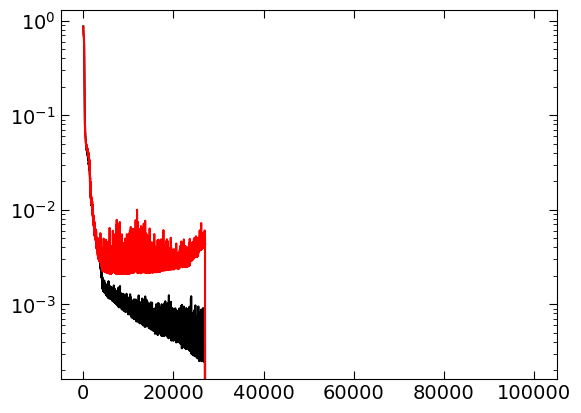

In [141]:
if Train:
    plt.yscale('log')
    plt.plot(nre.net.epochs,nre.net.epoch_loss,'k-')
    plt.plot(nre.net.epochs,nre.net.val_loss,'r-')
    plt.show()

## Data

In [142]:
# theta_true = np.array([[1.0,-1.0]]).T # y = 1 - x
# data = nre.simulator(theta_true)

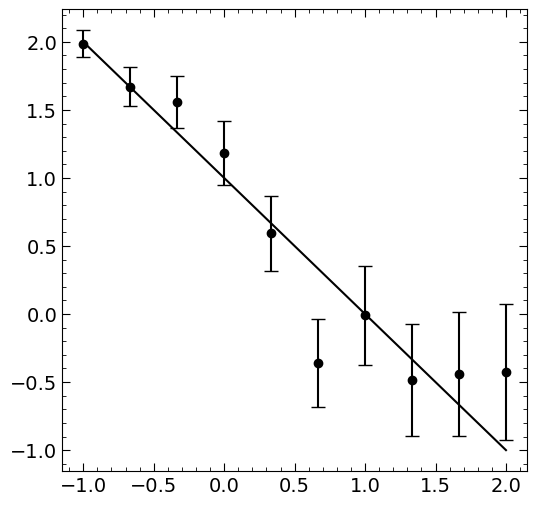

In [143]:
plt.figure(figsize=(6,6))
plt.errorbar(nre.xvals,data.T[0],yerr=nre.sigma,c='k',capsize=5,marker='o',ls='none')
plt.plot(nre.xvals,theta_true[0,0] + theta_true[1,0]*nre.xvals,'k-')
plt.minorticks_on()
plt.show()

In [144]:
theta_test = theta_true.copy()
ratio,F,theta_hat = analytical_nre(nre,data,theta_test)
Ctheta = linalg.inv(F)
print('analytical: {0:.3e}'.format(np.squeeze(ratio)))
print('predicted : {0:.3e}'.format(np.squeeze(nre.predict(data,theta_test))))

analytical: 7.068e+04
predicted : 1.653e+04


In [145]:
n_grid = 100
theta_vals = np.zeros((nparam,n_grid))
for p in range(nparam):
    theta_vals[p] = np.linspace(theta_hat[p,0]-3.5*np.sqrt(Ctheta[p,p]),theta_hat[p,0]+3.5*np.sqrt(Ctheta[p,p]),n_grid)
like_ana = np.zeros((n_grid,n_grid))
like_nre = np.zeros_like(like_ana)

start_time = time()
for ix in range(n_grid):
    for iy in range(n_grid):
        theta_vec= nre.cv([theta_vals[0,ix],theta_vals[1,iy]])
        ratio_this,F_this,theta_hat_this = analytical_nre(nre,data,theta_vec)
        like_ana[ix,iy] = np.squeeze(ratio_this)
        like_nre[ix,iy] = np.squeeze(nre.predict(data,theta_vec))
        nre.status_bar(iy + n_grid*ix,n_grid**2)

like_ratio_ratio = like_nre/like_ana

nre.time_this(start_time)

[....................] 100% done
0 min 1.16 seconds



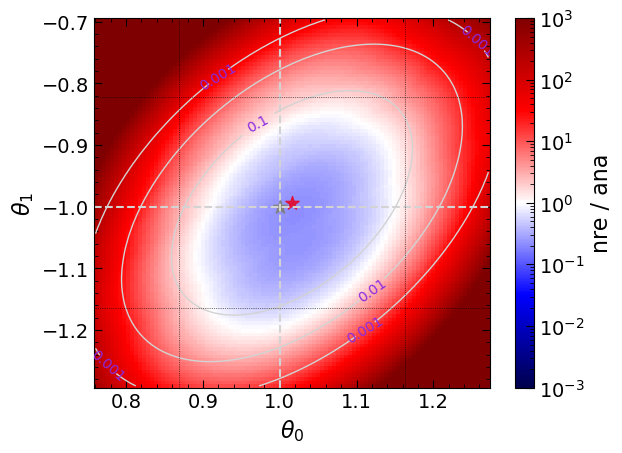

In [146]:
Vmin,Vmax = 1e-3,1e3
# convention of imshow: origin -> top left corner, x-axis pointing downward, y-axis pointing rightward
plt.xlabel("$\\theta_{{0}}$")
plt.ylabel("$\\theta_{{1}}$")
im = plt.imshow(like_ratio_ratio.T,norm=pltcol.LogNorm(vmin=Vmin,vmax=Vmax),cmap='seismic',
                origin='lower',aspect='auto',extent=[theta_vals[0].min(),theta_vals[0].max(),
                                                     theta_vals[1].min(),theta_vals[1].max()])
levels = np.sort([1e-3,0.01,0.1])
con = plt.contour(like_ana.T,levels=levels*like_ana.max(),colors='lightgray',linewidths=1,
                  origin='lower',extent=[theta_vals[0].min(),theta_vals[0].max(),
                                         theta_vals[1].min(),theta_vals[1].max()])
tobj = plt.clabel(con,colors='blueviolet')
clabs_old = []
for t in range(len(tobj)):
    clabs_old.append(tobj[t].get_text())
clabs_old = np.sort(np.unique(clabs_old).astype(int)).astype(str)
clabs = {clabs_old[l]:str(levels[l]) for l in range(len(levels))}
for t in range(len(tobj)):
    tobj[t].set(text=clabs[tobj[t].get_text()])
    
plt.scatter([theta_true[0]],[theta_true[1]],marker='*',s=100,color='gray')
plt.scatter([theta_hat[0]],[theta_hat[1]],marker='*',s=100,color='crimson')
# plt.scatter([theta_vals[0].max()],[theta_vals[1].min()],marker='*',s=200,color='k')
plt.axvline(theta_true[0],c='lightgray',lw=1.5,ls='--')
plt.axhline(theta_true[1],c='lightgray',lw=1.5,ls='--')

plt.axvline(theta_hat[0,0]-2*np.sqrt(Ctheta[0,0]),c='k',lw=0.5,ls=':')
plt.axvline(theta_hat[0,0]+2*np.sqrt(Ctheta[0,0]),c='k',lw=0.5,ls=':')
plt.axhline(theta_hat[1,0]-2*np.sqrt(Ctheta[1,1]),c='k',lw=0.5,ls=':')
plt.axhline(theta_hat[1,0]+2*np.sqrt(Ctheta[1,1]),c='k',lw=0.5,ls=':')

plt.colorbar(im,label='nre / ana')
plt.minorticks_on()
plt.show()

In [147]:
Ctheta[0,1]/np.sqrt(Ctheta[0,0]*Ctheta[1,1]),like_ratio_ratio.min()

(0.481546831566288, 0.21788364372575225)